# neural network
# - multilayer perceptron implementation project

## Difined classes
 - layer class;
   - It has forward pass and back-propagation implementations for a layer
   - To you use layer class multiLayerPerceptron class is needed
 - multiLayerPerceptron class;
   - It has the needed functions and some missing parts of layer class and
     it complates the layer class. 

 - Anıl Osman TUR

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
% matplotlib inline
random.seed(216)

### Neural Network generalizied layer

In [2]:
# for a hidden layer don't give any error function
# for output layer give a error function
class layer:
    def __init__(self, n_neuron, inputs, desired_outputs=None, activation=None,
                 d_activation=None, error=None, d_error=None):
        self.inputs = np.ones((inputs.shape[0], inputs.shape[1] + 1))  # ones for bias
        self.inputs[:, :-1] = inputs  # ones for biases added at last of every row of input
        # for arranging the weight matrix we need 
        self.n_neuron = n_neuron
        self.n_input = inputs.shape[1] + 1
        # if we give a cost functin neuron will be a output layer otherwise it will be a hidden layer
        if error != None:
            self.error_f = error
            self.labels = desired_outputs
            self.layer_type = "output"
            self.costs = np.ones((inputs.shape[0], n_neuron))
            self.errors = np.ones((inputs.shape[0], n_neuron))
            self.total_errors = np.zeros((inputs.shape[0], 1)) # for every input group there will be error sum
        else:
            if desired_outputs != None:
                self.labels = desired_outputs
                self.layer_type = "output"
                self.costs = np.zeros((inputs.shape[0], n_neuron))
                self.errors = np.zeros((inputs.shape[0], n_neuron))
                self.total_errors = np.zeros((inputs.shape[0], 1)) # for every input group there will be error sum
            else:
                self.layer_type = "hidden" 
            
        self.W = self.initWeight((n_neuron,   self.n_input))  # weights with bias
        # activating neurons
        self.v_net = np.dot(self.inputs, self.W.T)
        if activation == None:
            self.activation = None
            self.out = self.v_net
        else:
            self.activation = activation
            self.out = activation(self.v_net)  # V_out = sigmoid ( W*x + b )
        self.d_activation = d_activation
        self.grad = np.zeros((self.inputs.shape[0], self.n_neuron))  # local gradient
        self.grad_down = np.zeros((self.inputs.shape[0], self.n_neuron)) # gradient for before layer
        # for output neurons cost calcualtions 
        if self.layer_type == "output":
            self.cost(self.labels, self.out)
            if self.error_f != None:
                self.errors = self.error_f( self.costs )
            else:
                self.errors = self.costs
            self.total_errors = np.array([np.mean(self.errors, axis=1)])
        
        
        # cost fonction : desired - actvation output ( d - sigmoid ( W*x + b ) )
    def cost(self, desired, out):
        self.costs = desired - out
        
        # for first weight initializaiton random weights
    def initWeight(self, shape):
        W_values = np.asarray(np.random.uniform(
                    low=-np.sqrt(6. / (shape[0] + shape[1]))/100,
                    high=np.sqrt(6. / (shape[0] + shape[1]))/100,
                    size=shape))
        return W_values
        
    def fprop(self, inputs, desired_outputs=None):
        self.inputs = np.ones((inputs.shape[0], inputs.shape[1] + 1))  # ones for bias
        self.inputs[:, :-1] = inputs  # ones for biases added at last of every row of input
        self.v_net = np.dot(self.inputs, self.W.T) # V_net = W*x + b
        self.out = self.activation(self.v_net)  # V_out = sigmoid ( W*x + b )
        # if layer is output layer we need to calculate errors
        if self.layer_type == "output":
            if desired_outputs != None:
                self.labels = desired_outputs
                self.cost(self.labels, self.out)
                if self.error_f != None:
                    self.errors = self.error_f( self.costs )
                else:
                    self.errors = self.costs
                self.total_errors = np.array([np.mean(self.errors, axis=1)])
        return self.out

    # weight update function
    def update_w(self, lr):
        self.W = self.W + lr * np.dot(self.grad.T, self.inputs) # not sure about the sign here !!!!!

    # general back propagation for hidden and output layers 
    def bprop(self, backInput=None, lr=0.1): # if its a hidden layer we have to put back input
        if self.layer_type == "output":
            grad_above = self.costs
        else:
            grad_above = backInput # if its a hidden layer we have to take # not sure about "-" here
        self.grad = -self.d_activation(self.out) * grad_above
        self.grad_down = np.dot(self.grad, self.W[:,:-1])
        self.update_w(lr)
        return self.grad_down

### Multi Layer Perceptron 

In [3]:
# implementing the network

class multiLayerPerseptron():
    def __init__(self, inputs, labels, lr=0.1):
        if inputs.shape[0] == labels.shape[0]:
            self.inputs = inputs
            self.labels = labels
            self.inCounts = self.inputs.shape[0]
            self.lr = lr
            
            self.first_inputs = np.array( [self.inputs[0]] )
            self.first_labels = np.array( [self.labels[0]] ) 
        
            # layers
            self.layers = []
            self.layer = None
            self.layer_count = 0
            self.adding_end = False
            
        else:
            print "ERROR: inputs and labes not equal!"
        
    def add_layer(self, n_neuron, layer_type='hidden'):
        if layer_type != 'output' and layer_type != 'hidden':
            print "Unknown layer type. Please chose from hidden or output type."
        elif not self.adding_end:
            if self.layer_count == 0 and layer_type == 'output':
                print "You didn't add any hidden layer.This will a perseptron.\nYou can't add more layer. You can start training."
                self.layer = layer( n_neuron, self.first_inputs, desired_outputs=self.first_labels,
                              activation=self.sigmoid, d_activation=self.d_sigmoid, error=self.squared_error)
                self.layers.append(self.layer)
                self.adding_end = True
                self.layer_count += 1
            elif layer_type == 'output':
                print "Output layer will close adding you can't add more layer.\nYou can start training."
                self.layer = layer( n_neuron, self.layers[self.layer_count-1].out, desired_outputs=self.first_labels,
                              activation=self.sigmoid, d_activation=self.d_sigmoid, error=self.squared_error)
                self.layers.append(self.layer)
                self.adding_end = True
                self.layer_count += 1
            elif self.layer_count == 0:
                self.layer = layer( n_neuron, self.first_inputs, activation=self.sigmoid, d_activation=self.d_sigmoid)
                self.layers.append(self.layer)
                self.layer_count += 1
            else:
                self.layer = layer( n_neuron, self.layers[self.layer_count-1].out, activation=self.sigmoid, d_activation=self.d_sigmoid)
                self.layers.append(self.layer)
                self.layer_count += 1
            # layer adding finished
            if self.adding_end:
                print "first weigths:"
                self.printWeights()
                # seeing the outputs
                print "first outputs:"
                self.printOutputs()
        else:
            print "Layer couldn't created."
            print "Output layer had closed adding you can't add more layer.\nYou can start training."
        
        
    def forwardPass(self, inputs, labels=None, show=False):
        for i in xrange(len(self.layers)):
            if i == 0:
                self.layers[i].fprop(inputs)
            elif i == len(self.layers) - 1:
                self.layers[i].fprop(self.layers[i-1].out, desired_outputs=labels)
            else:
                self.layers[i].fprop(self.layers[i-1].out)
        if show:
            # seeing the outputs
            print "outputs"
            self.printOutputs()
        
    def backPropagate(self, show=False):
        for i in xrange(len(self.layers)-1, -1, -1):
            if i == len(self.layers)-1:
                self.layers[i].bprop(self.lr)
            else:
                self.layers[i].bprop( backInput=self.layers[i+1].grad_down, lr=self.lr )
        if show:
            #seeing the result of back propagation
            print "backpropagation done"
            self.printWeights()
        
    # train network for one epoch
    def train(self, show=False):
        # training for one epoch
        for inputCount in range(0 ,self.inCounts):
            self.forwardPass( np.array( [self.inputs[inputCount]] ), 
                              labels=np.array( [self.labels[inputCount]] ), show=show)
            self.backPropagate(show=show)
                
    # training network with training set
    def fit(self, epochs, show=False):
        print "Training started ..."
        for epoch in range(epochs):
            s = "Epoch :" +  str(epoch)
            print s,
            self.train(show=show)
            print '\r' * len(s),
        print "Trainging finalized."
        print "After trainging new weights: "
        self.printWeights()
    
    # making predictions
    def predict(self, x, show=False):
        predictions = []
        count = x.shape[0]
        print "predicting ..."
        for inputCount in range(0 ,count):
            self.forwardPass( np.array( [x[inputCount]] ) )
            predictions.append(self.layers[-1].out)
        print "done !"
        if show:
            print "predictions: "
            print "inputs: \n",  x
            print "predictions: \n", predictions
        return predictions
    
    # validating network with test set
    def validate(self, x, y, show=False):
        accuracy = 0.0
        falseCount = 0
        trueCount = 0
        allCount = x.shape[0]
        print "validating ..."
        for inputCount in range(0 ,allCount):
            self.forwardPass( np.array([x[inputCount]]) , labels=np.array([y[inputCount]]) )
            trueAnswer = np.argmax( y[inputCount] )
            if show:
                print "Test index :", inputCount
                print "Given answer : ",self.layers[-1].out
                print "True answer : ", y[inputCount]
            if np.argmax(self.layers[-1].out) == trueAnswer:
                error = self.layers[-1].costs[:,trueAnswer]
                if show:
                    print "Error: ", error
                if error < 0.5 and error > -0.5:
                    trueCount += 1
                else:
                    if show:
                        print "not sure but true."
                    trueCount += 1
            else:
                falseCount += 1
        print "from ",allCount," data, ",trueCount," true, ",falseCount, " false prediction."
        accuracy = float(trueCount) / allCount
        print("accuracy: {:.2f}%".format((accuracy) * 100))
        print "done !"
            
    # print layer types
    def printNet(self):
        print "Network Structure:"
        for i in range(len(self.layers)):
            print self.layers[i].layer_type, "layer with ", self.layers[i].n_neuron, "neuron"

    
    # printing weights
    def printWeights(self):
        for i in range(len(self.layers)):
            print self.layers[i].layer_type, " layer ", i, " weights: \n",self.layers[i].W
        
    def printOutputs(self):
        for i in range(len(self.layers)):
            print self.layers[i].layer_type, " layer ", i, " output: \n",self.layers[i].out
        
    def printErrors(self):
        print "output layer costs: \n", self.layers[-1].costs
        print "output layer errors: \n", self.layers[-1].errors
        print "output layer error average: \n", self.layers[-1].total_errors
    
    def plot_weights(self, l):
        plt.title('weights')
        plt.imshow(l.W, interpolation='nearest')
        plt.show()
        
    def plot_layers(self):
        for i in range(len(self.layers)):
            self.plot_weights(self.layers[i])
            
    # activation function
    def sigmoid( self, x ):
        return 1 / ( 1 + np.exp(x) )

    def d_sigmoid( self, out ):
        return out * ( 1 - out )
    
    def relu(self, x):
        return x * (x > 0)
    
    def d_relu(self, x):
        return (x > 0)
    
    def softmax( self, x ):
        exps = np.exp(x)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def d_softmax( self, out ):
        pass
    
    # loss functions
    def cross_entropy( self, out, t ):
        return -np.sum( t * np.log(out) + ( 1 - t ) * np.log(1 - out) )
    
    def d_cross_entropy( self, out, t ):
        pass
    
    def squared_error( self, cost ): # desired value and y as output of neurons
        return  np.square( cost ) / 2

    def d_squared_error( self, cost ): # a bit meaningless to use
        return cost

### Loading data

In [4]:
dataset_file = "/home/***/datasets/iris_plants/iris.mat"

def loadData(fileName):
    
    class_count = -1
    same_class_dataCount = 0
    data_class = ""
    last_data_class = ""
    input_model = []
    classes = []
    
    fileI = open(fileName, 'r')
    
    input_s = fileI.readline()[:-1] # reading without readline
    input_model = input_s.split(',')
    
    data = []
    while input_s != '':
        for i in range(4):
            input_model[i] = float(input_model[i])    
        data_class = input_model[4]
        if data_class == last_data_class:
            same_class_dataCount += 1
        else:
            class_count += 1
            classes.append(data_class)
        input_model[4] = class_count
        last_data_class = data_class
        
        data.append(input_model)
        input_s = fileI.readline()[:-1]
        input_model = input_s.split(',')
        
    fileI.close()
    return data, classes
data, classes = loadData(dataset_file)

random.shuffle(data)

### Data Normalization and label creation

In [5]:
data = np.array(data)
max_v = np.amax(data[:,:-1], axis=0)
min_v = np.amin(data[:,:-1], axis=0)

normalized_data = (data[:,:-1] - min_v) / (max_v - min_v)
labels = data[:,-1]

cato_labels = np.zeros((len(labels),len(classes)))
for i, label in enumerate(labels):
    cato_labels[i][label] = 1.0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
# test and train split
test_data = normalized_data[:20]
test_labels = cato_labels[:20]

train_data = normalized_data[20:]
train_labels = cato_labels[20:]
#print train_data[:10], "\n", train_labels[:10]

In [7]:
epochs = 200

mlp = multiLayerPerseptron(train_data, train_labels, lr=0.1)
mlp.add_layer( 6, layer_type='hidden')
mlp.add_layer( 3, layer_type='output')
mlp.fit(epochs)
print "train validation"
mlp.validate(train_data, train_labels)
print "test validation"
mlp.validate(test_data, test_labels, show=True)
mlp.printNet()

Output layer will close adding you can't add more layer.
You can start training.
first weigths:
hidden  layer  0  weights: 
[[  3.09804999e-03   6.13563704e-03  -6.94561343e-04  -4.04822929e-03
   -2.02633220e-03]
 [ -4.37241186e-03  -3.53520908e-03  -1.31677227e-03  -1.32251386e-03
   -5.46654891e-04]
 [  3.81274854e-03  -3.22154939e-03   4.72847581e-03   4.43556642e-03
   -5.66504663e-03]
 [ -5.71685424e-03   5.35010350e-03   7.12787658e-03  -6.62142327e-03
   -2.82549110e-03]
 [  2.16451176e-03   3.32032063e-03   5.22359340e-03   6.39008467e-04
    1.03332721e-03]
 [ -5.06724218e-05   6.04380589e-03   3.84108503e-03  -4.14315070e-03
    1.64221107e-03]]
output  layer  1  weights: 
[[-0.00561589 -0.00395673  0.00038798  0.0067894   0.00196047 -0.00396494
   0.00662062]
 [-0.00528252  0.00650969  0.00582567 -0.00283006  0.00292162  0.00665145
  -0.00451671]
 [ 0.00356357 -0.00644828 -0.00647517  0.00419943  0.0015961  -0.00056978
   0.00363451]]
first outputs:
hidden  layer  0  output

In [8]:
i =10

mlp.forwardPass(np.array([test_data[i]]), np.array([test_labels[i]]), show=True)
mlp.printErrors()
print test_labels[i]

outputs
hidden  layer  0  output: 
[[ 0.30834117  0.32655853  0.00509803  0.67938374  0.01565695  0.33977707]]
output  layer  1  output: 
[[ 0.00362274  0.2228513   0.86823435]]
output layer costs: 
[[-0.00362274 -0.2228513   0.13176565]]
output layer errors: 
[[  6.56213204e-06   2.48313516e-02   8.68109309e-03]]
output layer error average: 
[[ 0.011173]]
[ 0.  0.  1.]


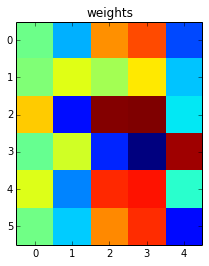

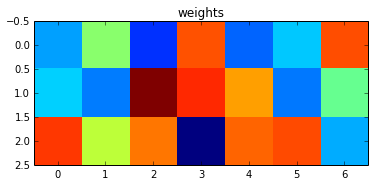

In [9]:
mlp.plot_layers()

In [10]:
# with another dataset
dataset_file = "/home/****/datasets/letters/letter-recognition.data"

def loadData(fileName):
    
    class_count = -1
    same_class_dataCount = 0
    data_class = ""
    last_data_class = ""
    input_model = []
    classes = []
    
    fileI = open(fileName, 'r')
    
    input_s = fileI.readline()[:-1] # reading without readline
    classes = set()
    data = []
    while input_s != '':
        input_model = input_s.split(',')
        for i in xrange(1,len(input_model)):
            input_model[i] = float(input_model[i])    
        data_class = input_model[0]
        classes.add(data_class)
        classes = list(classes)
        input_model[0] = classes.index(data_class)
        classes = set(classes)
        
        data.append(input_model)
        input_s = fileI.readline()[:-1]
        input_model = input_s.split(',')
        
    fileI.close()
    return data, classes
data, classes = loadData(dataset_file)

random.shuffle(data)

In [12]:
## normalization
data = np.array(data)
max_v = data[:,1:].max( axis=0)
min_v = data[:,1:].min( axis=0)
print max_v, min_v

normalized_data = (data[:,1:] - min_v) / (max_v - min_v)
labels = data[:,0]

cato_labels = np.zeros((len(labels),len(classes)))
for i, label in enumerate(labels):
    cato_labels[i][label] = 1.0

split = int(len(normalized_data) / 5)
print split, len(normalized_data)
# test and train split
test_data = normalized_data[:split]
test_labels = cato_labels[:split]

train_data = normalized_data[split:]
train_labels = cato_labels[split:]
#print train_data[:10], "\n", 

[ 15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
4000 20000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
epochs = 20

mlp = multiLayerPerseptron(train_data, train_labels, lr=0.1)
mlp.add_layer( 10, layer_type='hidden')
mlp.add_layer( len(classes), layer_type='output')
mlp.fit(epochs)
print "train validation"
mlp.validate(train_data, train_labels)
print "test validation"
mlp.validate(test_data, test_labels)
mlp.printNet()

Output layer will close adding you can't add more layer.
You can start training.
first weigths:
hidden  layer  0  weights: 
[[  5.81184323e-04   1.29297453e-03   4.33113636e-03   2.22882174e-03
    2.99904080e-03  -3.18360688e-03   4.63108570e-03  -1.02824416e-03
    2.50105766e-03  -4.49175525e-03   8.09137760e-04   3.63888508e-03
   -4.04735412e-03  -3.77948341e-03   2.39026422e-03  -2.39737309e-03
    1.51133888e-03]
 [ -6.63107723e-04   1.69920548e-03   3.19643801e-03   2.85087445e-03
   -3.13516449e-04   4.58848459e-03  -5.68074952e-04  -4.12068336e-03
   -1.65676353e-03   2.96360760e-03   2.40246504e-03  -2.94918002e-03
    2.79304083e-03   4.54588492e-03   1.75082093e-03   2.40639026e-03
   -4.70464196e-03]
 [ -3.87974375e-03   8.77992331e-04   1.93562474e-03   1.61412495e-03
    4.45166447e-03  -2.31337555e-03  -4.00322559e-03   4.24435472e-03
   -2.14955926e-03  -4.70089899e-03  -3.71072868e-03  -2.42706279e-04
   -2.89761352e-03   2.39828053e-03   9.46413779e-04   1.23161105e

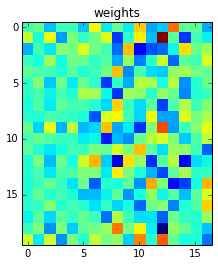

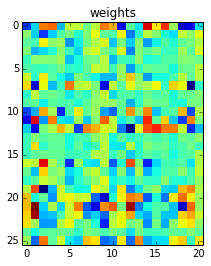

In [15]:
mlp.plot_layers()